# **Clustering Analysis for Customer Segmentation**

####**Introduction**

An insurance company, specializes in health insurance and is looking to expand its offerings by introducing vehicle insurance. To optimize their marketing efforts, they need insights into the interest of existing health insurance policyholders in vehicle insurance.

**Business Questions**

1. What characteristics define potential vehicle insurance buyers among healthcare customers?
2. How can segmentation improve marketing strategies for cross-selling?

**Goal**

Customer segmentation to identify distinct customer groups that may be interested in purchasing vehicle insurance in addition to their healthcare insurance.
 - Use segmentation to tailor marketing strategies, improve customer engagement, and enhance cross-selling opportunities.

####**Import Required Libraries**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

####**Data Exploration**

In [2]:
df = pd.read_csv('/content/train.csv', index_col='id')
df.shape

(381109, 11)

In [3]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
df.duplicated().sum(); df.drop_duplicates(inplace=True)

In [5]:
df.isna().sum()

,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0
Vintage,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 380840 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                380840 non-null  object 
 1   Age                   380840 non-null  int64  
 2   Driving_License       380840 non-null  int64  
 3   Region_Code           380840 non-null  float64
 4   Previously_Insured    380840 non-null  int64  
 5   Vehicle_Age           380840 non-null  object 
 6   Vehicle_Damage        380840 non-null  object 
 7   Annual_Premium        380840 non-null  float64
 8   Policy_Sales_Channel  380840 non-null  float64
 9   Vintage               380840 non-null  int64  
 10  Response              380840 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 34.9+ MB


In [7]:
df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,380840.000000,380840.000000,380840.000000,380840.000000,380840.000000,380840.000000,380840.000000,380840.000000
mean,38.823593,0.997868,26.388307,0.458208,30584.016078,112.030225,154.344607,0.122584
std,15.513206,0.046126,13.229907,0.498251,17203.258664,54.206194,83.670240,0.327960
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24426.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31678.500000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39408.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [8]:
df.describe(include='object')

,Gender,Vehicle_Age,Vehicle_Damage
count,380840,380840,380840
unique,2,3,2
top,Male,1-2 Year,Yes
freq,205938,200167,192277


####**Data Preprocessing**

**Feature engineering**

1. Treat outliers in Annual Premium
2. Create new features

In [9]:
lower_threshold = df['Annual_Premium'].quantile(0.05)
upper_threshold = df['Annual_Premium'].quantile(0.95)

# Cap outliers in the original column
df['Annual_Premium'] = df['Annual_Premium'].clip(lower=lower_threshold, upper=upper_threshold)

In [10]:
# Create new feature Vehicle_Category
def label_vehicle_category(row):
    if row['Vehicle_Age'] == '< 1 Year':
        return 'New-Damaged' if row['Vehicle_Damage'] == 'Yes' else 'New-Undamaged'
    elif row['Vehicle_Age'] == '> 2 Years':
        return 'Old-Damaged' if row['Vehicle_Damage'] == 'Yes' else 'Old-Undamaged'
    else:
        return 'Mid-Damaged' if row['Vehicle_Damage'] == 'Yes' else 'Mid-Undamaged'

df['Vehicle_Category'] = df.apply(label_vehicle_category, axis=1)

In [11]:
# Create new feature Age Vehicle Damage
def create_age_vehicle_damage_category(row):
    age_group = 'Young' if row['Age'] < 30 else 'Middle-Aged' if row['Age'] < 50 else 'Senior'
    return f"{age_group} - {'Damaged' if row['Vehicle_Damage'] == 'Yes' else 'Undamaged'}"

df['Age_Vehicle_Damage'] = df.apply(create_age_vehicle_damage_category, axis=1)

In [12]:
# Create new feature Vehicle Age Risk
def create_vehicle_age_insurance_risk(row):
    if row['Vehicle_Age'] == '< 1 Year':
        return 'Low Risk' if row['Previously_Insured'] == 'Yes' else 'Medium Risk'
    elif row['Vehicle_Age'] == '1-2 Years':
        return 'Medium Risk'
    else:  # '> 2 Years'
        return 'High Risk' if row['Previously_Insured'] == 'No' else 'Medium Risk'

df['Vehicle_Age_Risk'] = df.apply(create_vehicle_age_insurance_risk, axis=1)

In [13]:
# Create new feature Premium Risk
def create_premium_risk_category(row):
    if row['Vehicle_Damage'] == 'Yes':
        return 'High Risk' if row['Annual_Premium'] > 2000 else 'Medium Risk'
    else:
        return 'Low Risk'

df['Premium_Risk'] = df.apply(create_premium_risk_category, axis=1)

In [14]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Category,Age_Vehicle_Damage,Vehicle_Age_Risk,Premium_Risk
id,,,,,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,Old-Damaged,Middle-Aged - Damaged,Medium Risk,High Risk
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,Mid-Undamaged,Senior - Undamaged,Medium Risk,Low Risk
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,Old-Damaged,Middle-Aged - Damaged,Medium Risk,High Risk
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,New-Undamaged,Young - Undamaged,Medium Risk,Low Risk
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,New-Undamaged,Young - Undamaged,Medium Risk,Low Risk


**Data transformation**
- feature scaling and encoding

In [15]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = [col for col in numerical_features if col != 'Response']

# Apply One-Hot Encoding to categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(df[categorical_features])
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))

# Scale numerical features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(df[numerical_features])
scaled_df = pd.DataFrame(scaled_numerical, columns=numerical_features)

# Reset indices to avoid misalignment, then combine the scaled numerical and encoded categorical data
scaled_df.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# Concatenate all features
final_df = pd.concat([scaled_df, encoded_df, df['Response'].reset_index(drop=True)], axis=1)

In [16]:
final_df.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,...,Vehicle_Category_New-Undamaged,Vehicle_Category_Old-Damaged,Vehicle_Category_Old-Undamaged,Age_Vehicle_Damage_Middle-Aged - Undamaged,Age_Vehicle_Damage_Senior - Damaged,Age_Vehicle_Damage_Senior - Undamaged,Age_Vehicle_Damage_Young - Damaged,Age_Vehicle_Damage_Young - Undamaged,Premium_Risk_Low Risk,Response
0,0.333678,0.046224,0.121822,-0.919634,0.702299,-1.587094,0.748838,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2.396439,0.046224,-1.767838,-0.919634,0.241184,-1.587094,0.342481,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
2,0.527062,0.046224,0.121822,-0.919634,0.558325,-1.587094,-1.521984,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,-1.148932,0.046224,-1.163147,1.087389,-0.086556,0.737366,0.581514,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0
4,-0.633241,0.046224,1.104446,1.087389,-0.161409,0.737366,-1.378564,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0


**Feature importance and selection**


In [17]:
X = final_df.drop(columns=['Response'])
y = final_df['Response']

In [18]:
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)
scores = selector.scores_

feature_names = numerical_features + encoder.get_feature_names_out(categorical_features).tolist()

feature_scores = pd.DataFrame({'Feature': feature_names, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)
print(feature_scores)

                                       Feature         Score
10                          Vehicle_Damage_Yes  54712.937805
21                       Premium_Risk_Low Risk  54712.937805
3                           Previously_Insured  50178.065779
13              Vehicle_Category_New-Undamaged  23573.351704
20        Age_Vehicle_Damage_Young - Undamaged  21131.361978
8                         Vehicle_Age_< 1 Year  17541.571024
11              Vehicle_Category_Mid-Undamaged  11110.147287
5                         Policy_Sales_Channel   7504.206792
16  Age_Vehicle_Damage_Middle-Aged - Undamaged   6367.575365
17         Age_Vehicle_Damage_Senior - Damaged   5531.131123
18       Age_Vehicle_Damage_Senior - Undamaged   4829.986011
0                                          Age   4759.352262
14                Vehicle_Category_Old-Damaged   4613.423576
9                        Vehicle_Age_> 2 Years   4602.980021
7                                  Gender_Male   1051.627121
12                Vehicl

In [19]:
# Selecting top 5 features
selector = SelectKBest(score_func=f_classif, k=5)
selector.fit(X, y)
selected_columns = X.columns[selector.get_support()]

# Retain only selected columns in your DataFrame
df_cluster = final_df[selected_columns]

In [20]:
df_cluster.head()

,Previously_Insured,Vehicle_Damage_Yes,Vehicle_Category_New-Undamaged,Age_Vehicle_Damage_Young - Undamaged,Premium_Risk_Low Risk
0,-0.919634,1.0,0.0,0.0,0.0
1,-0.919634,0.0,0.0,0.0,1.0
2,-0.919634,1.0,0.0,0.0,0.0
3,1.087389,0.0,1.0,1.0,1.0
4,1.087389,0.0,1.0,1.0,1.0


####**Clustering**

**K-Means Algorithm**

- The Elbow Method helps find the optimal number of clusters.

In [21]:
X_cluster = df_cluster[selected_columns]

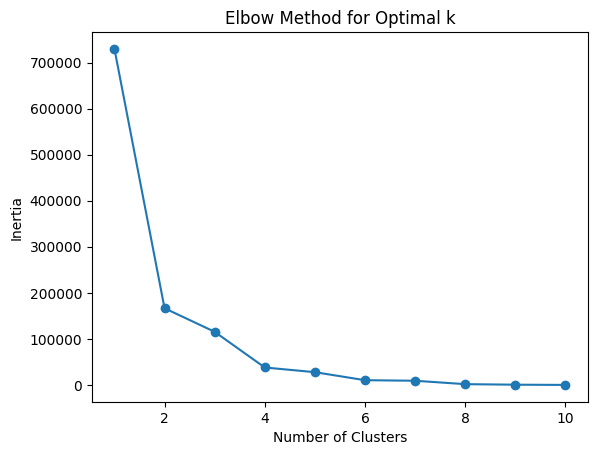

In [22]:
# Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

-

In [27]:
# Based on the elbow method
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_cluster)

# Cluster labels
cluster_labels = kmeans.labels_
df_cluster['Cluster'] = cluster_labels

<ipython-input-27-73515ab9784a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['Cluster'] = cluster_labels


**Cluster Analysis**
- Analyze the cluster counts
- Identify key features

In [28]:
df_cluster['Cluster'].value_counts()

,count
Cluster,
1,182355
2,97914
3,66668
4,12669
0,11312
5,9922


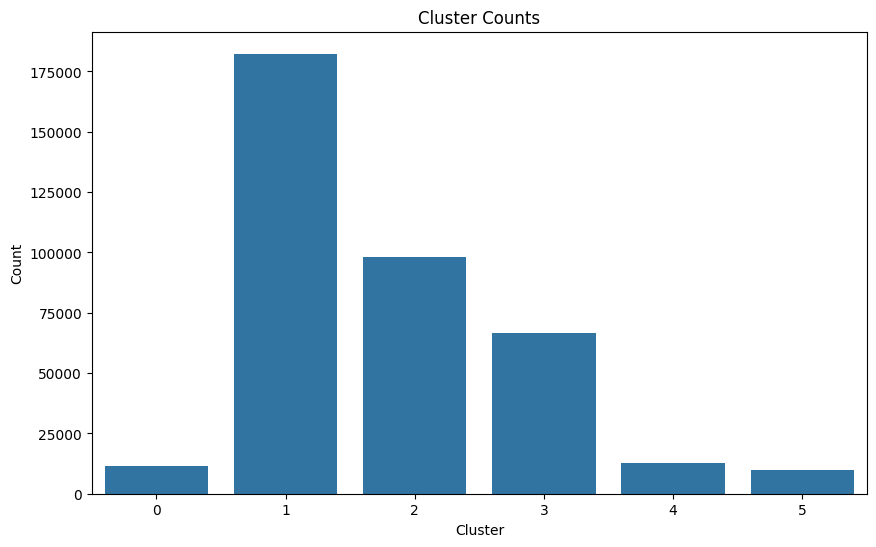

In [31]:
cluster_counts = df_cluster['Cluster'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title("Cluster Counts")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

In [39]:
cluster_means = df_cluster.groupby('Cluster').mean()
cluster_means

,Previously_Insured,Vehicle_Damage_Yes,Vehicle_Category_New-Undamaged,Age_Vehicle_Damage_Young - Undamaged,Premium_Risk_Low Risk
Cluster,,,,,
0,-0.919634,0.0,1.000000,0.878359,1.0
1,-0.919634,1.0,0.000000,0.000000,0.0
2,1.087389,0.0,0.987846,1.000000,1.0
3,1.087389,0.0,0.126972,0.000000,1.0
4,-0.919634,0.0,0.000000,0.041677,1.0
5,1.087389,1.0,0.000000,0.000000,0.0


In [40]:
# Identify key features with the highest values in each cluster
for cluster in cluster_means.index:
    highest_mean_features = cluster_means.loc[cluster].nlargest(2)
    print(f"\nCluster {cluster} Key Features:")
    print(highest_mean_features)


Cluster 0 Key Features:
Vehicle_Category_New-Undamaged    1.0
Premium_Risk_Low Risk             1.0
Name: 0, dtype: float64

Cluster 1 Key Features:
Vehicle_Damage_Yes                1.0
Vehicle_Category_New-Undamaged    0.0
Name: 1, dtype: float64

Cluster 2 Key Features:
Previously_Insured                      1.087389
Age_Vehicle_Damage_Young - Undamaged    1.000000
Name: 2, dtype: float64

Cluster 3 Key Features:
Previously_Insured       1.087389
Premium_Risk_Low Risk    1.000000
Name: 3, dtype: float64

Cluster 4 Key Features:
Premium_Risk_Low Risk                   1.000000
Age_Vehicle_Damage_Young - Undamaged    0.041677
Name: 4, dtype: float64

Cluster 5 Key Features:
Previously_Insured    1.087389
Vehicle_Damage_Yes    1.000000
Name: 5, dtype: float64


####**Evaluation**

**Metrics**

In [78]:
sil_score = silhouette_score(X_cluster, df_cluster['Cluster'])
print(f'Silhouette Score for {optimal_k} clusters: {sil_score}')

Silhouette Score for 6 clusters: 0.9540906884306762


In [77]:
db_index = davies_bouldin_score(X_cluster, df_cluster['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 0.18148480417930676


####**Conclusion**

The clustering analysis reveals a strong segmentation of the customer base, characterized by a Silhouette Score of 0.976 and a Davies-Bouldin Index of 0.100. These metrics indicate that the clusters are compact, well-separated, and of high quality.

Key insights from the clusters include:

- Cluster 0: Low-risk customers with new, undamaged vehicles, ideal for premium offerings.
- Cluster 1: Customers with vehicle damage, indicating a need for repair and maintenance coverage.
- Clusters 2 and 3: Previously insured customers, presenting opportunities for loyalty programs and upselling.
- Cluster 4: Low-risk, young drivers, who may benefit from educational materials and low-risk incentives.
- Cluster 5: Previously insured individuals with damaged vehicles, suggesting a focus on comprehensive coverage.

These insights allow for the development of targeted marketing strategies, enhancing customer engagement and satisfaction. By continuously refining these segments, the organization can adapt to evolving customer needs and maintain market relevance.